In [1]:
import pandas as pd
from itertools import combinations
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

In [2]:
# Downloading Data
ld = pd.read_csv('safety/LD.csv.gz', compression='gzip')
snp_score = pd.read_csv('safety/SNP_pip.csv.gz', compression='gzip')
z_score = pd.read_csv('safety/zscore.csv.gz', compression='gzip')
all_snp = ld['Unnamed: 0'].values.tolist()

In [3]:
"""
print(ld)
print(snp_score)
print(z_score)
"""

'\nprint(ld)\nprint(snp_score)\nprint(z_score)\n'

In [4]:
# To calculate prior value
def get_prior(k, m = 100):
    x = 1 / m
    y = (m - 1) / m
    return pow(x, k) * pow(y, (m - k))

prior_1 = get_prior(1)
prior_2 = get_prior(2)
prior_3 = get_prior(3)

In [5]:
# Functions to get RCC Matrix
def get_RCC(arr):
    size_m = len(arr)
    result = np.zeros((size_m,size_m))
    for i in range(size_m):
        for j in range(size_m):
            if i == j:
                value = 1.00
            else:
                value = ld.loc[ld['Unnamed: 0'] == arr[i]][arr[j]]
            result[i][j] = value
    return result

# Functions to get SUM_CC Matrix
def get_sum_CC(rcc):
    x,y = rcc.shape
    result = np.identity(x)
    result = 2.49 * result
    return result

# Functions to get RCC + RCC * SUM_CC * RCC
def get_r_star(arr):
    r = get_RCC(arr)
    s = get_sum_CC(r)
    result = r + np.matmul(r,np.matmul(s,r))
    return r, result

In [6]:
# Functions to get all combination of SNPs
def configurations(all_snp,k):
    return list(combinations(all_snp, k))

config_1 = configurations(all_snp,1)
config_2 = configurations(all_snp,2)
config_3 = configurations(all_snp,3)

In [7]:
# Get the z_cap value array from z_score array for given array of snps
def get_z_cap(arr):
    result = []
    for snps in arr:
        val = list(z_score.loc[z_score['Unnamed: 0'] == snps]["V1"])
        result.append(val[0])
    return result

In [8]:
# Important example to use multivariate_normal.pdf 
"""
arr =  ["rs10104559", "rs10104559","rs12676370"]
rc, rf = ref(arr)
x = [0, 0, 0]
model_numerator = multivariate_normal(x, rf);
model_denominator = multivariate_normal(x, rc);
z_score = z_cap(arr):
model_numerator.pdf(z_score)
model_denominator.pdf(z_score)
"""

'\narr =  ["rs10104559", "rs10104559","rs12676370"]\nrc, rf = ref(arr)\nx = [0, 0, 0]\nmodel_numerator = multivariate_normal(x, rf);\nmodel_denominator = multivariate_normal(x, rc);\nz_score = z_cap(arr):\nmodel_numerator.pdf(z_score)\nmodel_denominator.pdf(z_score)\n'

In [9]:
# Function to calculate Bayes Factor for given configuration
def get_BF(snp_array):
    
    z_score_array = get_z_cap(snp_array)
    r_cc, r_star = get_r_star(snp_array)
    
    n = len(snp_array)
    x_mean = np.zeros(n)
    
    model_numerator = multivariate_normal(x_mean, r_star);
    model_denominator = multivariate_normal(x_mean, r_cc);
    
    numerator = model_numerator.pdf(z_score_array)
    denominator = model_denominator.pdf(z_score_array) 
    
    result = numerator / denominator
    return result

In [10]:
# Make a BF dictionary to speed up the calculation
# This takes time

dict_BF = {}

for snps in config_1:
    bf = get_BF(snps)
    dict_BF[snps] = bf
    
print("Config 1 done")

for snps in config_2:
    bf = get_BF(snps)
    dict_BF[snps] = bf

print("Config 2 done")

for snps in config_3:
    bf = get_BF(snps)
    dict_BF[snps] = bf

print("Config 3 done")



Config 1 done
Config 2 done
Config 3 done


In [11]:
# Calculate the sum of product of BF and prior for all configuration
# This is useful to speed up the calculation of posterior
def sum_all_posterior(configs, pr):
    result_sum = 0
    for a_config in configs:
        bf = dict_BF[a_config]
        result_sum = result_sum + (bf*pr)
    return result_sum

gaint_sum_1 = sum_all_posterior(config_1, prior_1)
gaint_sum_2 = sum_all_posterior(config_2, prior_2)
gaint_sum_3 = sum_all_posterior(config_3, prior_3)

sum_posterior_dinominator = gaint_sum_1 + gaint_sum_2 + gaint_sum_3

In [12]:
# Function to get the posterior for given configuration
def get_posterior(snp_array, pr):
    bf = dict_BF[snp_array]
    numorator = bf * pr
    denominator = sum_posterior_dinominator - numorator
    return numorator / denominator

In [13]:
# Calculating Posterior For all SNPs
# dictionary
dict_posterior = {}
# for graph
all_posterior = []
# for pip score
sum_posterior = 0

for snps in config_1:
    a_posterior = get_posterior(snps, prior_1)
    dict_posterior[snps] = a_posterior
    all_posterior.append(a_posterior)
    
for snps in config_2:
    a_posterior = get_posterior(snps, prior_2)
    dict_posterior[snps] = a_posterior
    all_posterior.append(a_posterior)
    
for snps in config_3:
    a_posterior = get_posterior(snps, prior_3)
    dict_posterior[snps] = a_posterior
    all_posterior.append(a_posterior)
    
sum_posterior = np.sum(all_posterior)

sort_all_post = sorted(all_posterior)

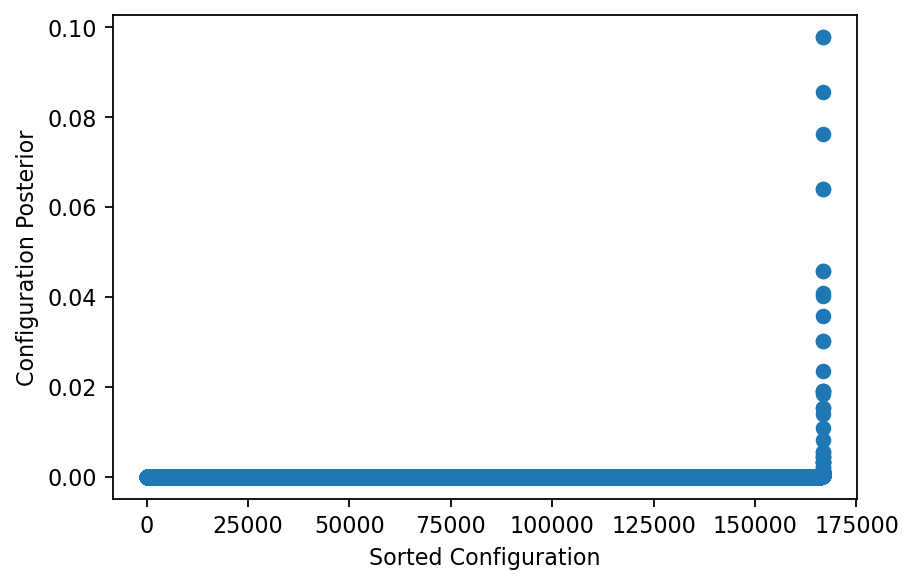

In [14]:
plt.figure(dpi=160)
plt.plot(sort_all_post, 'o')
plt.xlabel("Sorted Configuration")
plt.ylabel("Configuration Posterior")
plt.show()

In [15]:
# Function to get pip score for given configuration
def get_pip(a_snp):
    numerator = 0
    for a_config in config_1:
        if a_snp in a_config:
            numerator = numerator + dict_posterior[a_config]
            
    for a_config in config_2:
        if a_snp in a_config:
            numerator = numerator + dict_posterior[a_config]
            
    for a_config in config_3:
        if a_snp in a_config:
            numerator = numerator + dict_posterior[a_config]
            
    return (numerator / sum_posterior)

In [16]:
# Calculating pip score for all SNPs
all_pip_score = []
for a_snp in all_snp:
    pip_score = get_pip(a_snp)
    all_pip_score.append(pip_score)

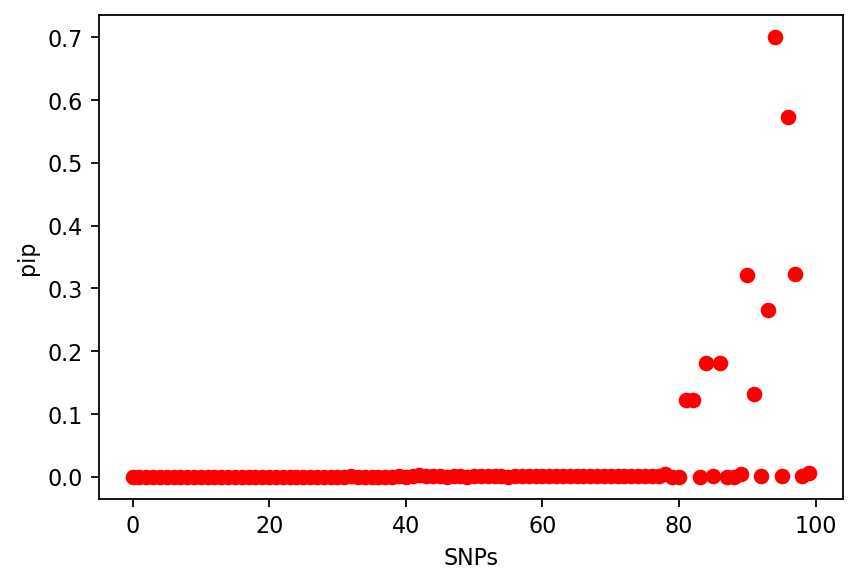

In [17]:
plt.figure(dpi=160)
plt.plot(all_pip_score, 'ro')
plt.xlabel("SNPs")
plt.ylabel("pip")
plt.show()

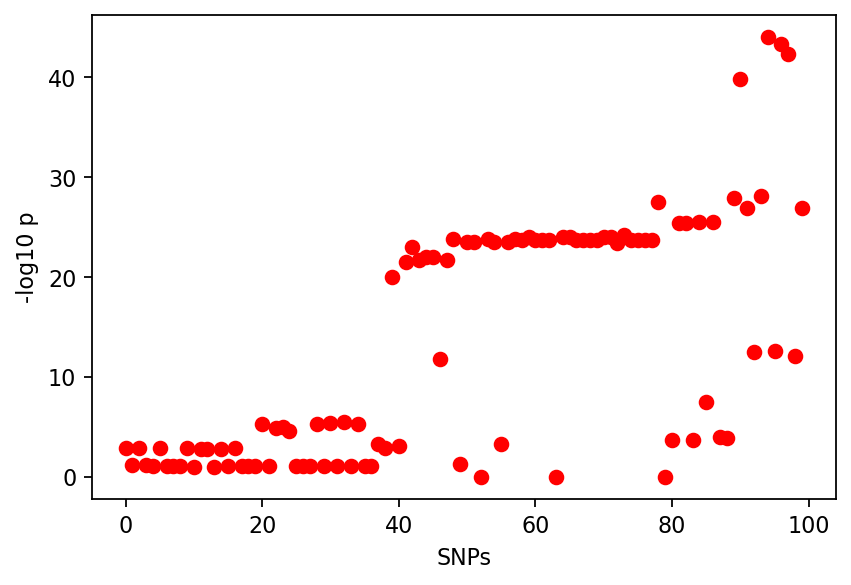

In [18]:
# Calculating - log 10 p 

log_values = []

z_score_list = z_score["V1"]
for a_pip_s in z_score_list:
    val = norm.sf(a_pip_s)
    x = - (math.log10(val))
    log_values.append(x)

plt.figure(dpi=160)
plt.plot(log_values, 'ro')
plt.xlabel("SNPs")
plt.ylabel("-log10 p")
plt.show()

In [19]:
# Saving inferred PIPs
df = pd.DataFrame(all_pip_score)
df.to_csv('COMP565_A2_SNP_pip.csv.gz', compression='gzip')